# Problem: Solve the following equation

$$\frac{d}{dx}(e^x\frac{du(x)}{dx})=-e^x[cos(x) - 2sin(x) -xcos(x) - xsin(x)]$$

$$u(0) = 0, u(1) = cos(1)$$


In [1]:
print(
"""
python setup
pip install sympy
pip install numpy
pip install scipy
pip install matplotlib
pip install jupyter
jupyter notebook

shift + enter to execute code block in jupyter
""")




python setup
pip install sympy
pip install numpy
pip install scipy
pip install matplotlib
pip install jupyter
jupyter notebook

shift + enter to execute code block in jupyter



### verify solution u = xcos(x) 

$$\frac{d}{dx}(e^x\frac{d[xcos(x)]}{dx})=-e^x[cos(x) - 2sin(x) -xcos(x) - xsin(x)]$$
$$xcos(x)_{x=0}=0, xcos(x)_{x=1}=cos(1)$$



In [2]:
import sympy as sp
from sympy import *
import numpy as np

#analytical solution
x=symbols('x')
u = symbols('u', cls=Function)

left = (exp(x)*u(x).diff(x)).diff(x)
right = (-x*sin(x) + cos(x))*exp(x) + (-x*cos(x) - 2*sin(x))*exp(x)

diffeq = sp.Eq(left, right)
analytic = sp.dsolve(diffeq, u(x))
print(analytic)
print(analytic.subs(x,0))
print(analytic.subs(x,1))

Eq(u(x), C1 + C2*exp(-x) + x*cos(x))
Eq(u(0), C1 + C2)
Eq(u(1), C1 + C2*exp(-1) + cos(1))


In [3]:
#bench mark solution xcos(x) when C1=C2=0
u = x * cos(x)

y=sp.diff(exp(x)*diff((u)))
start=0.
end=1.
print(y)
print(start*cos(start))
print(end*cos(end))
print(N(cos(1)))

(-x*sin(x) + cos(x))*exp(x) + (-x*cos(x) - 2*sin(x))*exp(x)
0
0.540302305868140
0.540302305868140


# Finite element solution

u is the function we want to know
$$-(cu^{'})^{'}=f$$
apply a known test function v(x) to interact with the original function, try to get information
$$-(cu^{'})^{'}v=fv$$
integrate within the boundaries a=0 and b=1
$$-\int_{0}^1(cu^{'})^{'}v\,dx=\int_{0}^1 fv\,dx$$
the left side:
$$\int_{0}^1(cu^{'})^{'}v\,dx=\int_{0}^1v\,d(cu^{'})=cu^{'}v|_{0}^{1} - \int_{0}^1(cu^{'})\,dv$$
so our equation can be written as:
$$c(1)u^{'}(1)v(1) - c(0)u^{'}(0)v(0) + \int_{0}^1cu^{'}v^{'}\,dx =\int_{0}^1 fv\,dx$$
choose v(x) so that v(1)=v(0)=0, we have
$$\int_{0}^1(cu^{'}v^{'})\,dx=\int_{0}^1 fv\,dx$$

In [4]:
import numpy as np

#N cells
N = 5
#size of one cell
h = (end-start)/N

#f function
def f(x):
    return -np.exp(x) * (np.cos(x) - 2*np.sin(x) - x*np.cos(x) - x*np.sin(x))

#c function
def c(x):
    return np.exp(x)

#bondary condition
u0 = 0
u1 = np.cos(1)

h

0.2

In [5]:
#P matrix [0, 1/(N-1), 2/(N-1),..., N-1/(N-1)]
P = np.arange(start, end+h, h)
P

array([0. , 0.2, 0.4, 0.6, 0.8, 1. ])

In [6]:
#T matrix
"""
N=5
array([[0, 1, 2, 3, 4],
       [1, 2, 3, 4, 5]])
"""
row = 2 #node per cell
T = np.array([[i + j for i in range(N+1)] for j in range(row)])
T[row-1,N] = 0
T

array([[0, 1, 2, 3, 4, 5],
       [1, 2, 3, 4, 5, 0]])

### choose test funtions v as the following 

$$
\phi_{j}(x_{i}) = \delta_{i,j} \left\{
    \begin{array}\\
        1 & \mbox{if } i = j \\
        0 & \mbox{else.}
    \end{array}
\right.
$$

$$ U_{h} = span\{\phi_{j}\}_{j=1}^{N+1}$$
$$ \sum_{j=1}^{N+1}C_{j}\phi_{j}(x)=0$$
$$
\phi_{1}(x) = \left\{
    \begin{array}\\
        \frac{x_{2}-x}{h} & \mbox{if } \ x \in [x_{1}, x_{2}] \\
        0 & \mbox{else.}
    \end{array}
\right.
$$

$$
\phi_{j}(x) = \left\{
    \begin{array}\\
        \frac{x-x_{j-1}}{h} & \mbox{if } \ x \in [x_{j-1}, x_{j}] \\
        \frac{x_{j+1}-x}{h} & \mbox{if } \ x \in [x_{j}, x_{j+1}] \\
        0 & \mbox{else.}
    \end{array}
\right.
$$

$$
\phi_{N+1}(x) = \left\{
    \begin{array}\\
        \frac{x-x_{N}}{h} & \mbox{if } \ x \in [x_{N}, x_{N+1}] \\
        0 & \mbox{else.}
    \end{array}
\right.
$$

$$u=\sum_{0}^{N}u_{j}\phi_{j}$$


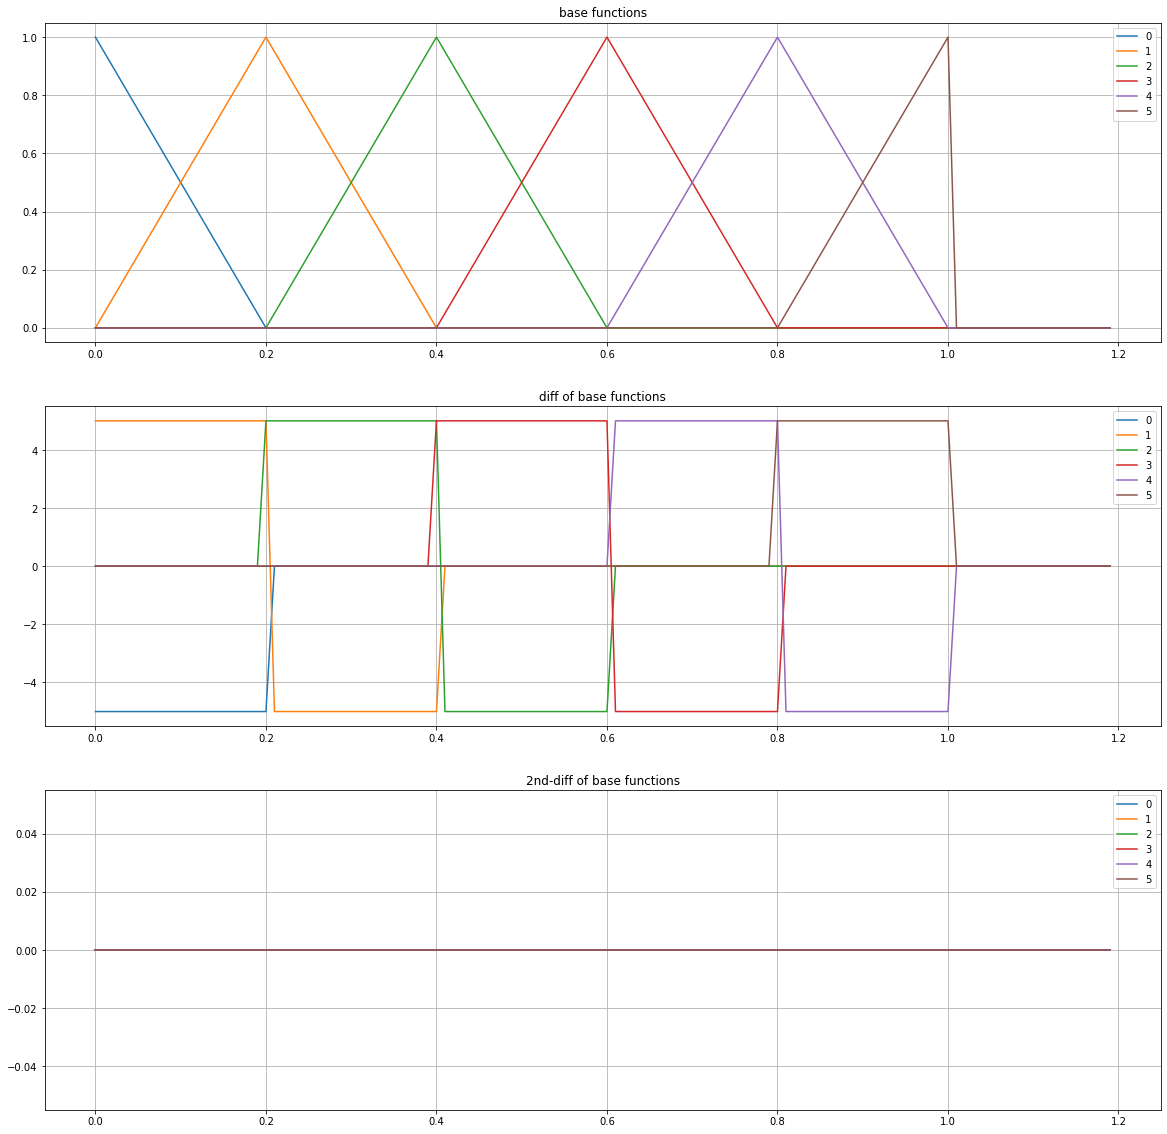

In [7]:
import matplotlib.pyplot as plt
def linearBase(j, level=0):
    if j==0:
        phi = Piecewise((0, x<P[0]),((P[1]-x)/h, x<=P[1]),(0, True))
    elif j==N:
        phi = Piecewise((0, x<P[N-1]),((x-P[N-1])/h, x<=P[N]),(0, True))
    else:
        phi = Piecewise((0, x<P[j-1]),((x-P[j-1])/h, x<=P[j]), ((P[j+1]-x)/h, x<=P[j+1]), (0, True))
    return diff(phi, x, level)
    
def phiarray(xarray, j, level=0):
    l = xarray.copy()
    for n in range(0, xarray.size):
        phi = linearBase(j, level)
        #l[n] = phi(xarray[n], j)
        l[n] = phi.subs(x, xarray[n])
    return l
    
t=np.arange(start, end+h, h/20)

fig1 = plt.figure(1, figsize=(20, 20))
chart1 = fig1.add_subplot(311)
chart2 = fig1.add_subplot(312)
chart3 = fig1.add_subplot(313)
for j in range(N+1):
    chart1.plot(t, phiarray(t, j), label=j)
chart1.grid()
chart1.legend()
chart1.title.set_text('base functions')

for j in range(N+1):
    chart2.plot(t, phiarray(t, j, 1), label=j)
chart2.grid()
chart2.legend()
chart2.title.set_text('diff of base functions')

for j in range(N+1):
    chart3.plot(t, phiarray(t, j, 2), label=j)
chart3.grid()
chart3.legend()
chart3.title.set_text('2nd-diff of base functions')
               
plt.show()

=>
$$\sum_{j=0}^{N}u_{j}[\int_{0}^{1}c\phi_{j}^{'}\phi_{i}^{'}\, dx]=\int_{0}^{1}f\phi_{i}\, dx,\, (i=0, 1, 2,...N)$$
$$a_{i,j}=\int_{0}^{1}c\phi_{j}^{'}\phi_{i}^{'}\, dx=\sum_{n=0}^{N-1}\int_{x_{n}}^{x_{n+1}}c\phi_{j}^{'}\phi_{i}^{'}\, dx$$
$$b_{i}=\int_{0}^{1}f\phi_{i}\, dx=\sum_{n=0}^{N-1}\int_{x_{n}}^{x_{n+1}}f\phi_{i}\, dx, (i=0, 1, 2,...N)$$

=>
$$a_{i,j}:\,except\,\alpha=0,1\,and\,\beta=0,1\,other\,itegrations\,are\,all\,zero$$

$$
r_{p} = \phi_{n+\alpha}^{'}\phi_{n+\beta}^{'} = \left\{
    \begin{array}\\
        \frac{1}{h}^{2} & \mbox{if } \alpha\,and\,\beta\,same \\
        -\frac{1}{h}^{2} & \mbox{else.}
    \end{array}
\right.
$$

$$
r = \int_{x_{n}}^{x_{n+1}}cr_{p}\,dx
$$
$$r=\int_{P[n]}^{P[n+1]}c r_{p}\,dx$$
$$i=T[\beta,n], j=T[\alpha,n]$$

### solve A matrix

In [8]:
from scipy.integrate import quad

#absolute value of integral for any pairs of base functions on [0,1]
rp= (1/h)*(1/h)
#x2=lambda x: c(x)*rp

A=np.zeros((N+1, N+1))
for n in range(N):
    for alpha in [0,1]:
        for beta in [0,1]:
            i=T[beta,n]
            j=T[alpha,n]
            rp = linearBase(j, level=1) * linearBase(i, level=1)
            #integrate
            r=quad(lambda t: c(t)*rp.subs(x, t),P[n],P[n+1])
            A[i,j]=A[i,j] + r[0]
A

array([[  5.53506895,  -5.53506895,   0.        ,   0.        ,
          0.        ,   0.        ],
       [ -5.53506895,  12.29561744,  -6.76054849,   0.        ,
          0.        ,   0.        ],
       [  0.        ,  -6.76054849,  15.01790106,  -8.25735257,
          0.        ,   0.        ],
       [  0.        ,   0.        ,  -8.25735257,  18.34290577,
        -10.0855532 ,   0.        ],
       [  0.        ,   0.        ,   0.        , -10.0855532 ,
         22.4040757 , -12.3185225 ],
       [  0.        ,   0.        ,   0.        ,   0.        ,
        -12.3185225 ,  12.3185225 ]])

### solve b array
$$b_{i}=\sum_{n=0}^{N-1}\int_{x_{n}}^{x_{n+1}}f\phi_{i}\, dx, \,\, (i=0, 1, 2,...N)$$

$$b_{j}'s\, integral = \left\{
    \begin{array}\\
        f(x)\frac{x-x_{j-1}}{h} & \mbox{if } \ x \in [x_{j-1}, x_{j}] \\
        f(x)\frac{x_{j+1}-x}{h} & \mbox{if } \ x \in [x_{j}, x_{j+1}] \\
        0 & \mbox{else.}
    \end{array}
\right.
$$

$$b_{i}= \int_{P[i-1]}^{P[i]}f(x) \frac{x-P[i-1]}{h}\, dx + \int_{P[i]}^{P[i+1]}f(x) \frac{P[i+1]-x}{h}\, dx$$

In [9]:
b=np.zeros((N+1))  
for n in range(N):
    for alpha in [0,1]:
        linearBase(n+alpha)
        v = lambda t: f(t)*linearBase(n+alpha).subs(x, t)
        r = quad(v,P[n],P[n+1])
        b[n+alpha] = b[n+alpha] + r[0]
        
b

array([-0.08383855, -0.07780029,  0.12248126,  0.4244413 ,  0.8423327 ,
        0.59104493])

### edge condition u0 and u1
$$c(1)u^{'}(1)v(1) - c(0)u^{'}(0)v(0) + \int_{0}^1cu^{'}v^{'}\,dx =\int_{0}^1 fv\,dx$$
choose test function v(x) so that v(1)=v(0)=0, we have
$$\int_{0}^1(cu^{'}v^{'})\,dx=\int_{0}^1 fv\,dx$$
the above assumption is not correct at our bondary, our test function has bondary value 1 instead of 0, actually
$$\phi_{x0}=1\,and\,\phi_{x_{N}}=1$$

so the first row and last row in A and b should be replaced by u0=0 and u1=cos(1) boundary conditions:
$$[1,0,0...0]x_{0}=0$$
$$...$$
$$[0,0,0...1]x_{N}=cos(1)$$

In [10]:
A[0,0:]=0
A[N,0:]=0
A[0,0]=1
A[N,N]=1
b[0]=0
b[N]=np.cos(1)
print(A)
print(b)

[[  1.           0.           0.           0.           0.
    0.        ]
 [ -5.53506895  12.29561744  -6.76054849   0.           0.
    0.        ]
 [  0.          -6.76054849  15.01790106  -8.25735257   0.
    0.        ]
 [  0.           0.          -8.25735257  18.34290577 -10.0855532
    0.        ]
 [  0.           0.           0.         -10.0855532   22.4040757
  -12.3185225 ]
 [  0.           0.           0.           0.           0.
    1.        ]]
[ 0.         -0.07780029  0.12248126  0.4244413   0.8423327   0.54030231]


### solve Ax=b

In [11]:
u=np.linalg.solve(A,b)
u

array([5.61623440e-16, 1.97058781e-01, 3.69904851e-01, 4.96586251e-01,
       5.58220122e-01, 5.40302306e-01])

### compare finite-element solution with the analytical solution xcos(x)
$$u=\sum_{0}^{N}x_{j}\phi_{j} \,\,\,\,VS.\,\,\,\,xcos(x)$$

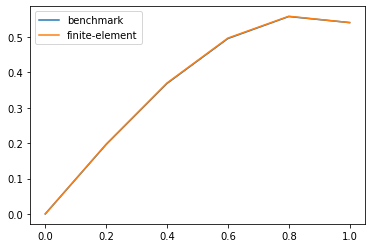

In [12]:
def ufinite(array):
    l = array.copy()
    for n in range(array.size):
        l[n] = 0
        for j in range(N+1):
            #l[n] = l[n] + phi(array[n], j)*x[j]
            l[n] = l[n] + linearBase(j).subs(x,array[n])*u[j]
    return l
plt.plot(P, P*np.cos(P), label='benchmark')
plt.plot(P, ufinite(P), label='finite-element')
plt.legend()